# Compute diversity coefficient from distance matrix for c4, WikiText, The Pile
Plot histograms and heatmaps of pairwise distances 

In [1]:
import task_similarity
import numpy as np
import os

In [4]:
# global_results = np.load('global_results.npy', allow_pickle=True).item()
def compute_div_and_plot(embeddings_dict, mode='bs', num_tasks=200, save=False):
    
    div_results = {}
    distance_matrix_lst, hm_title_lst, hist_title_lst, labels = [], [], [], []
    diversity_lst, ci_lst, num_task_lst, bar_x_lst = [], [], [], []
    upper_bounds, lower_bounds = [], []
    loss_lst, loss_title_lst = [], []
    for config, value in embeddings_dict.items():
        if len(value) == 2:
            embeddings, losses = value
        else:
            embeddings = value
            losses = []
        d, max_num_tasks, bs, is_pt, is_ft, num_epochs = config
        print("=> ", d, num_tasks, bs, is_pt, is_ft, num_epochs)
        
        # compute distance matrix and diversity coefficient
        # otherwise, load from dictionary of cached results.
        if config not in global_results:
            print("COMPUTING PAIRWISE DISTANCES AND DIVERSITY COEFFICIENT")
            distance_matrix: np.ndarray = task_similarity.pdist(embeddings[:num_tasks], 
                                                                distance='cosine')

            div, ci, total = task_similarity.stats_of_distance_matrix(distance_matrix, get_total=True)
            print(f'Diversity: {(div, ci, total)=}')
            div, std, total = task_similarity.stats_of_distance_matrix(distance_matrix, variance_type='std', get_total=True)
            print(f'Diversity: {(div, std, total)=}')
            print(div, div + ci, div - ci)

            global_results[(d, num_tasks, bs, is_pt, is_ft, num_epochs)] = [distance_matrix, div, ci, std, total]
        else:
            print("LOAD FROM DICT")
            distance_matrix, div, ci, std, total = global_results[(d, num_tasks, bs, is_pt, is_ft, num_epochs)]
            print(f'Diversity: {(div, ci, total)=}')
            print("Average CE loss: ", np.mean(losses))
        upper_bounds.append(div+ci)
        lower_bounds.append(div-ci)

        distance_matrix_lst.append(distance_matrix)

        # title and labels for heatmap 
        pretrained = 'pt' if is_pt else 'rand'
        finetuned = 'ft' if is_ft else 'no ft'
        model_config = "(" + pretrained + ", " + finetuned + ")"
        if mode == 'epochs':
            hm_title_lst.append("Pairwise Distance between Tasks, GPT-2 (pt, ft on " + str(num_epochs) + " epochs)")
        labels.append(list(range(num_tasks)))

        # title for histogram
        if mode == 'epochs':
            hist_title_lst.append("Distribution of Task2Vec Distances, GPT-2 (pt, ft on " + str(num_epochs) + " epochs)")
        if mode == None:
            hist_title_lst.append("Distribution of Task2Vec Distances, " + d)
        if mode == 'epochs' and len(losses)>0:
            loss_lst.append(losses)
            loss_title_lst.append("Distribution of Finetuning CE Loss, GPT-2 (pt, ft on " + str(num_epochs) + " epochs)")
        
        # labels for barplot
        diversity_lst.append(div)
        ci_lst.append(ci)
        num_task_lst.append(num_tasks)
        if mode == 'epochs':
            bar_x_lst.append(str(num_epochs) + " epochs")
    
    if mode == 'epochs':
        save_file = d + "_" + str(num_tasks) + "tasks_128bs_gpt2" + str(model_config) + "_" + str(num_epochs) + "epochs"
          
    if save:
        save_title = "epochs/histogram_" + save_file
        main_title = None
    else:
        save_title=None
        main_title = None
    if len(distance_matrix_lst) == 1:
        task_similarity.plot_histogram_of_distances(distance_matrix_lst[0], hist_title_lst[0],
                                                                show_plot=True, bins_width=0.001)
        task_similarity.plot_histogram_of_distances(loss_lst[0], loss_title_lst[0],
                                                                show_plot=True)
    else:
        task_similarity.plot_multi_histogram_of_distances(distance_matrix_lst, hist_title_lst, save_file=save_title,
                                                                    main_title=main_title, show_plot=True)
        if len(losses)>0:
            task_similarity.plot_multi_histogram_of_distances(loss_lst, loss_title_lst, save_file=save_title,
                                                                    main_title=main_title, show_plot=True,xlabel="CE Loss per Task")

=>  The Pile 200 512 True True 10
LOAD FROM DICT!!
Diversity: (div, ci, total)=(0.24631398310882494, 3.0343503555892277e-05, 4901.401949882507)
Average CE loss:  nan
=>  c4 200 512 True True 10
COMPUTING!!
Diversity: (div, ci, total)=(0.23741350871234682, 2.785377261988259e-05, 4724.528823375702)
Diversity: (div, std, total)=(0.23741350871234682, 0.0020045880822674757, 4724.528823375702)
0.23741350871234682 0.2374413624849667 0.23738565493972694
=>  WikiText-103 200 512 True True 10
LOAD FROM DICT!!
Diversity: (div, ci, total)=(0.21401120816343394, 7.932868761169883e-05, 4258.823042452335)
Average CE loss:  nan


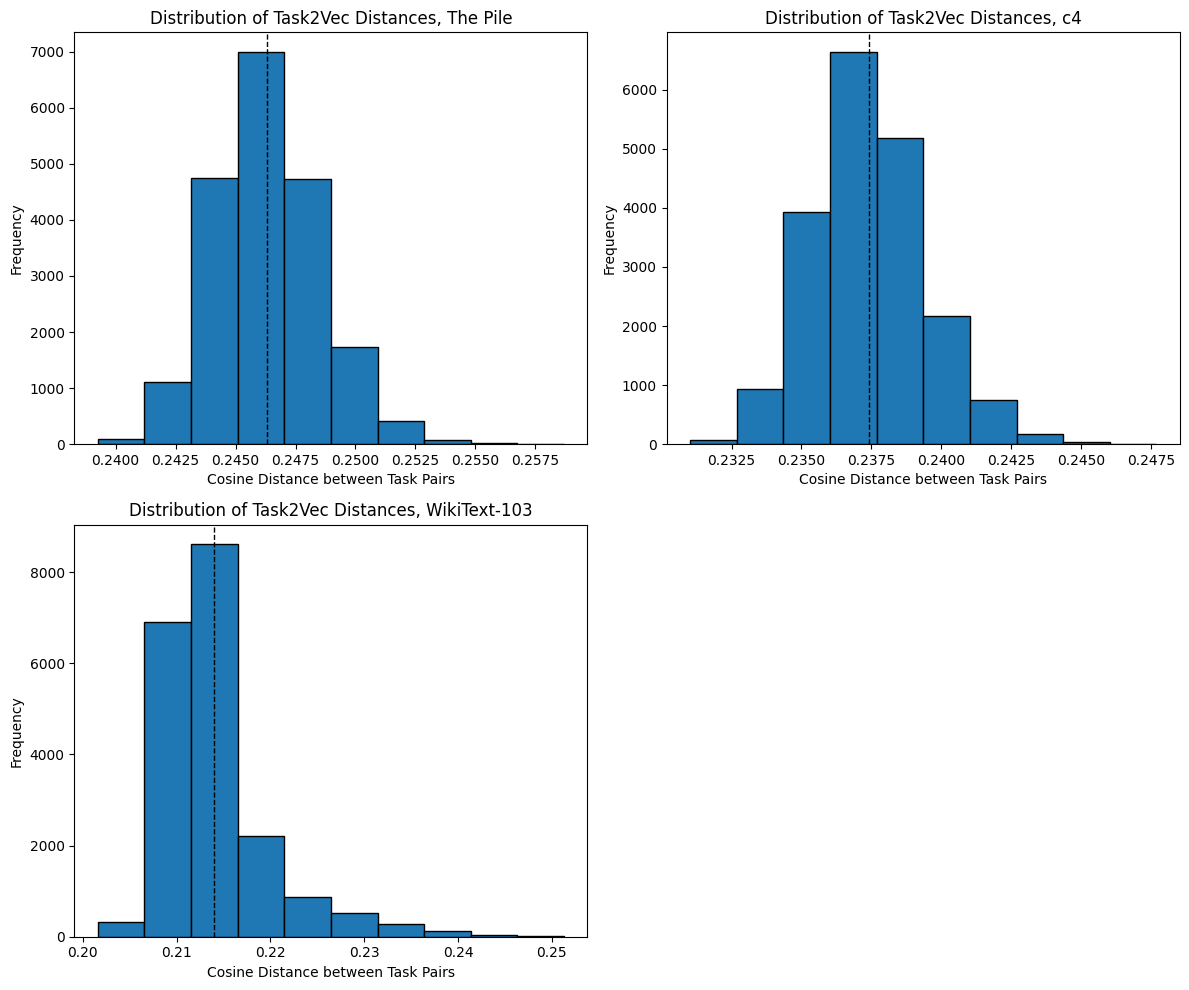

In [6]:
import re
import collections

datasets = ['../output/output_c4_500tasks_bs512_gpt2_pt_ft',
            '../output/output_wt_200tasks_bs512_gpt2_pt_ft',
            '../output/output_thepile_200tasks_bs512_gpt2_pt_ft']
results_dir = '../results'
for lst, mode in zip([datasets], [None]):
    embeddings_dict = {}
    num_tasks_lst = []
    for output_dir in lst:
        file_dir = os.path.join(results_dir, output_dir)
        # parse through output file name to extract hyperparams
        # used to compute diversity coefficient.
        regex = "output_([a-zA-Z0-9]+)_([0-9]+)tasks_bs([0-9]+)_([a-zA-Z0-9]+)_([a-zA-Z]+)_([a-zA-Z]+)"
        if mode == 'epochs' and  output_dir != 'from_vm3/output_c4_500tasks_bs128_gpt2_pt_ft':
            regex += '_([0-9]+)epochs'
        match = re.search(regex, output_dir)
        if mode == 'epochs' and  output_dir != 'from_vm3/output_c4_500tasks_bs128_gpt2_pt_ft':
            ds, _, bs, model, is_pt, is_ft, num_epochs = match.groups()
            bs, is_pt, is_ft, num_epochs = int(bs), is_pt == 'pt', is_ft == 'ft', int(num_epochs)
        else:
            ds, _, bs, model, is_pt, is_ft = match.groups()
            bs, is_pt, is_ft = int(bs), is_pt == 'pt', is_ft == 'ft'
            num_epochs = 10
        if ds == "wt":
            ds = "WikiText-103"
        if ds == "thepile":
            ds = "The Pile"
        
        regex = "embeddings_([0-9]+)tasks"
        file_dict = {int(re.search(regex, file).groups()[0]): file for file in os.listdir(file_dir) if "embeddings_" in file}
        file_dict = dict(collections.OrderedDict(sorted(file_dict.items())))
        
        max_num_tasks = max([key for key in file_dict])
        file = file_dict[max_num_tasks]
        embeddings = np.load(os.path.join(file_dir, file), allow_pickle=True)
        if mode == 'epochs' and  output_dir != 'from_vm3/output_c4_500tasks_bs128_gpt2_pt_ft':# or mode == None:
            losses = np.load(os.path.join(file_dir, "loss_200tasks.npy"), allow_pickle=True)
            embeddings_dict[(ds, max_num_tasks, bs, is_pt, is_ft, num_epochs)] = embeddings, losses
        else:
            embeddings_dict[(ds, max_num_tasks, bs, is_pt, is_ft, num_epochs)] = embeddings
        num_tasks_lst.append(max_num_tasks)
    compute_div_and_plot(embeddings_dict, mode=mode)#, save=True)

In [ ]:
og_global_results = np.load('global_results.npy', allow_pickle=True).item()
for k in og_global_results:
    if k not in global_results.keys():
        assert(True == False)
        
if len(og_global_results) > len(global_results):
    assert True == False

np.save('global_results.npy', global_results)

# Compute diversity coefficient of concatenated c4 and WikiText
Plot histogram and violin plot

In [1]:
import task_similarity
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import collections
import matplotlib.pyplot as plt

In [8]:
c4_and_wiki_combo = ['from_vm1/output_c4_500tasks_bs512_gpt2_pt_ft', 
                     'from_vm1/output_wt_200tasks_bs512_gpt2_pt_ft']
results_dir = '../results'
for lst, mode in zip([c4_and_wiki_combo], ['c4 and WikiText-103']):
    embeddings_dict = {}
    num_tasks_lst = []
    for output_dir in lst:
        file_dir = os.path.join(results_dir, output_dir)
        
        # parse through output file name to extract hyperparams
        # used to compute diversity coefficient.
        if mode == "The Pile":
            ds = "The Pile"
            model = "gpt2"
            bs, is_pt, is_ft = 512, True, True
        else:
            regex = "output_([a-zA-Z0-9]+)_([0-9]+)tasks_bs([0-9]+)_([a-zA-Z0-9]+)_([a-zA-Z]+)_([a-zA-Z]+)"
            if mode == 'epochs' and  output_dir != 'from_vm3/output_c4_500tasks_bs128_gpt2_pt_ft':
                regex += '_([0-9]+)epochs'
            match = re.search(regex, output_dir)
            ds, _, bs, model, is_pt, is_ft = match.groups()
            bs, is_pt, is_ft = int(bs), is_pt == 'pt', is_ft == 'ft'
        
        if mode == "The Pile":
            regex = "([a-zA-Z]+_[a-zA-Z]+)embeddings_50tasks"
            print(file_dir)
            file_dict = {int(re.search(regex, file).groups()[0]): file for file in os.listdir(file_dir) if "embeddings_50tasks" in file}
            file_dict = dict(collections.OrderedDict(sorted(file_dict.items())))
        else:
            regex = "embeddings_([0-9]+)tasks"
            file_dict = {int(re.search(regex, file).groups()[0]): file for file in os.listdir(file_dir) if "embeddings_" in file}
            file_dict = dict(collections.OrderedDict(sorted(file_dict.items())))
            
        max_num_tasks = max([key for key in file_dict])
        file = file_dict[max_num_tasks]
        embeddings = np.load(os.path.join(file_dir, file), allow_pickle=True)
        
        key = (mode, 400, bs, is_pt, is_ft)
        if key in embeddings_dict:
            embeddings_dict[key] = np.concatenate((embeddings_dict[key], embeddings[:200]), axis=0)
        else:
            embeddings_dict[key] = embeddings[:200]
        num_tasks_lst.append(max_num_tasks)

=>  c4 and WikiText-103 400 512 True True
LOAD FROM DICT!!
Diversity: (div, ci, total)=(0.2711076653817841, 0.00032221173820216816, 21634.391697466373)
Average CE loss:  nan


C:\Users\alycialee\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\alycialee\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


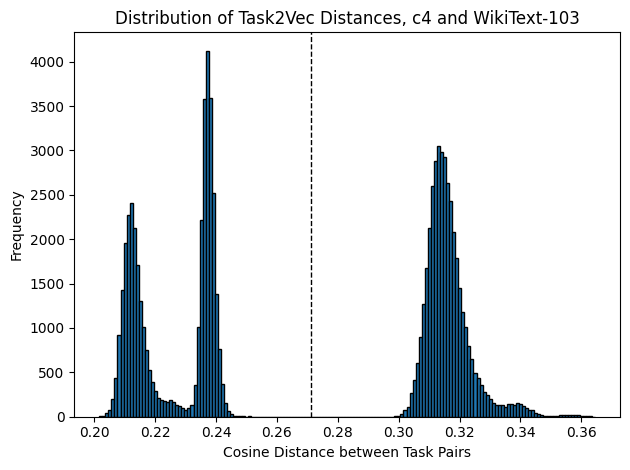

In [9]:
save = False

div_results = {}
distance_matrix_lst, hm_title_lst, hist_title_lst, labels = [], [], [], []
diversity_lst, ci_lst, num_task_lst, bar_x_lst = [], [], [], []
upper_bounds, lower_bounds = [], []
loss_lst, loss_title_lst = [], []

# global_results = np.load('global_results_concat.npy', allow_pickle=True).item()
for config, value in embeddings_dict.items():
    if len(value) == 2:
        embeddings, losses = value
    else:
        embeddings = value
        losses = []
    d, num_tasks, bs, is_pt, is_ft = config
    print("=> ", d, num_tasks, bs, is_pt, is_ft)
    if config not in global_results:
        print("COMPUTING PAIRWISE DISTANCES AND DIVERSITY COEFFICIENT")
        distance_matrix: np.ndarray = task_similarity.pdist(embeddings[:num_tasks], 
                                                            distance='cosine')

        div, ci, total = task_similarity.stats_of_distance_matrix(distance_matrix, get_total=True)
        print(f'Diversity: {(div, ci, total)=}')
        div, std, total = task_similarity.stats_of_distance_matrix(distance_matrix, variance_type='std', get_total=True)
        print(f'Diversity: {(div, std, total)=}')
        print(div, div + ci, div - ci)

        global_results[config] = [distance_matrix, div, ci, std, total]
    else:
        print("LOAD FROM DICT")
        distance_matrix, div, ci, std, total = global_results[config]
        print(f'Diversity: {(div, ci, total)=}')
        print("Average CE loss: ", np.mean(losses))
        
    upper_bounds.append(div+ci)
    lower_bounds.append(div-ci)

    distance_matrix_lst.append(distance_matrix)

    # histogram
    hist_title_lst.append("Distribution of Task2Vec Distances, " + d)
    if mode == 'epochs' and len(losses)>0:# or mode == None:
        loss_lst.append(losses)
        loss_title_lst.append("Distribution of Finetuning CE Loss, GPT-2 (pt, ft on " + str(num_epochs) + " epochs)")

if save:
    save_title = "save"
    main_title = None
else:
    save_title=None
    main_title = None
if len(distance_matrix_lst) == 1:
    task_similarity.plot_histogram_of_distances(distance_matrix_lst[0], hist_title_lst[0],
                                                         show_plot=True, bins_width=0.001)
else:
    task_similarity.plot_multi_histogram_of_distances(distance_matrix_lst, hist_title_lst, save_file=save_title,
                                                               main_title=main_title, show_plot=True)
    task_similarity.plot_multi_histogram_of_distances(loss_lst, loss_title_lst, save_file=save_title,
                                                               main_title=main_title, show_plot=True,xlabel="CE Loss per Task")

In [10]:
# get pairwise distances segmented by dataset source per task
tasklabel_distance_dict = {}
def flatten(distance_matrix):
    triu = np.triu(distance_matrix)
    distance_matrix = triu[triu != 0.0]
    return distance_matrix.flatten()

# get distances between tasks each from c4
distance_matrix_c4_only = flatten(distance_matrix[:200,:200])
tasklabel_distance_dict['label'] = ['c4 and c4'] * len(list(distance_matrix_c4_only))
tasklabel_distance_dict['dist'] = list(distance_matrix_c4_only)
print(len(list(distance_matrix_c4_only)))

# get distances between tasks each from WikiText-103
distance_matrix_wt_only = flatten(distance_matrix[200:,200:])
tasklabel_distance_dict['label'] += ['WT-103 and WT-103'] * len(list(distance_matrix_wt_only))
tasklabel_distance_dict['dist'] += list(distance_matrix_wt_only)
print(len(list(distance_matrix_wt_only)))

# get distances between tasks where one is from c4 and the other from WikiText-103
distance_matrix_both = distance_matrix[:200,200:].flatten()
tasklabel_distance_dict['label'] += ['c4 and WT-103'] * len(list(distance_matrix_both))
tasklabel_distance_dict['dist'] += list(distance_matrix_both)
print(len(list(distance_matrix_both)))

19900
19900
40000


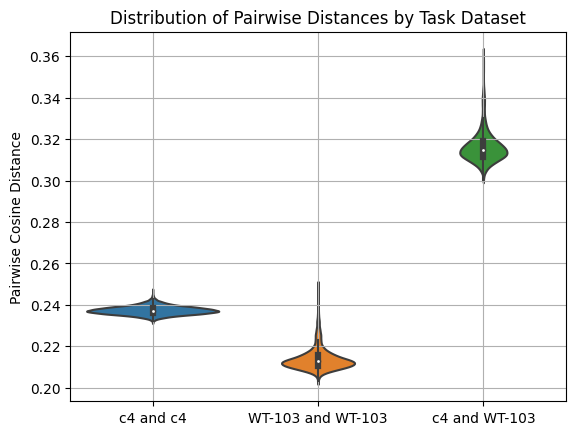

In [11]:
df = pd.DataFrame.from_dict(tasklabel_distance_dict)
sns.violinplot(x="label", y="dist",  data=df, cut = 0)
plt.xlabel("")
plt.ylabel("Pairwise Cosine Distance")
plt.title("Distribution of Pairwise Distances by Task Dataset")
plt.grid(True)
plt.show()

In [ ]:
np.save('global_results_concat.npy', global_results)